# Imports ( mainly uses Pytorch for deep learning )

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import cv2
import os
from zipfile import ZipFile


%reset -f

import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision import datasets, transforms,models
import helper
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import numpy 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import timeit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.optim as optim

import torch
torch.cuda.empty_cache()


import torch
from torch.utils.data import Dataset, TensorDataset, random_split
from torchvision import transforms

import os

random_seed = 42
torch.manual_seed(random_seed);
torchvision.__version__

'0.9.1+cu101'

# Data for Task 01
## Created a data folder only for Task 01
### Contains Positive smile vs No smile

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Classificon_rusteze/data/task_01

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Classificon_rusteze/data/task_01


In [ ]:
#!unzip data.zip -d "./"  ### takes in the .zip file and extracts it..

In [6]:
train_data_dir = './train_data'
val_data_dir = './val_data'
classes = os.listdir(train_data_dir)
print(classes)

['NOT smile', 'positive smile']


In [7]:
##################################  Defining a class to divide into subsets so that different transforms can be applied to train and valid sets (Data augmentation..)

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

#### Data Augmentation done only for training set
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),                            ### Change this according to the input of network..
        transforms.ColorJitter(contrast=[0.9,1.2]),  ### Random change in contrast
        transforms.RandomRotation(degrees = (-20,20)),  ### Random rotaion of image since not all images are straigtly alligned.
        transforms.RandomHorizontalFlip(p=0.5),             ### flipping
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),                         ### Change this according to the input of network..
        transforms.ToTensor(),
    ]),
}

In [10]:
########################################################  Setting up data...

train_dataset = ImageFolder(train_data_dir)
val_dataset = ImageFolder(val_data_dir)

train_ds = DatasetFromSubset(
    train_dataset, transform= data_transforms['train']
)
val_ds = DatasetFromSubset(
    val_dataset, transform= data_transforms['val']
)

train_bs=16  ### train batch size
val_bs = 32  ### Validation batch size
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=train_bs,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=val_bs,shuffle=True)

print("No. of training batches",len(train_dl))
print( "No. of validation batches",len(val_dl))

No. of training batches 272
No. of validation batches 46


torch.Size([16, 3, 224, 224])


torch.Size([32, 3, 224, 224])


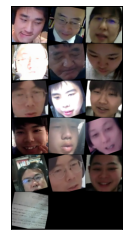

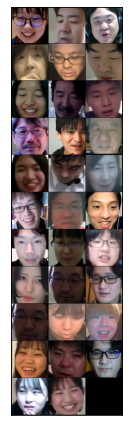

In [11]:
######################################################## Displaying data. of a batch
def show_batch(dl):
    for images, labels in dl:
        print(images.size())
        fig, ax = plt.subplots(figsize=(2,20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=3).permute(1, 2, 0))
        break

show_batch(train_dl)
print('\n')
show_batch(val_dl)

# Choose GPU (cuda) for fast computation

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# RESNET 18 Architecuture
### With pretrained weights on Image Net data.

####  Added a Classification head for binary classification.

#### All weights are updated in backprop step.

#### Loss : Cross Entropy, 

#### Evaluation metric : Accuracy

In [13]:
class ResNet18():
  def __init__(self,device,pretrained = True):
    super().__init__()

    self.model = models.resnet18(pretrained=pretrained).to(device)  
    for param in self.model.parameters():
      param.requires_grad = True                                         ##### Keep this in mind
      
    self.model.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.Linear(256, 2)).to(device)

    def forward(self,x):
      return self.model(x)

In [22]:
def train(model, device, train_loader, criterion, optimizer, epoch, model_saving_epochs,model_dir):
    model.train()
                                                                                             ###########
    train_loss = 0
    correct_preds = 0
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target = data.to(device),target.to(device)
        
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model.forward(data)

        ## find correct preds

        # calculate the loss (use cross entropy in pytorch)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output,target) 
        train_loss += loss  
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct_preds += pred.eq(target.view_as(pred)).sum().item()
                                                                 ######### Acumulates loss for every batch
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
    #print(len(train_loader.dataset) )
    Avg_train_loss = train_loss.item()/ len(train_loader.dataset)                  ### Divinding the accumulated losses with len of test data
    Avg_train_acc = 100. * correct_preds / len(train_loader.dataset)
                                                                                   ### Same as test loss calculation..
    print('\nEpoch: {} ;train_loss {:.4f} ; train_acc {:.2f}'.format(epoch,Avg_train_loss,Avg_train_acc))

    for save_e in model_saving_epochs:
      if epoch == save_e:
            torch.save(model, os.path.join(model_dir, 'resnet18_epoch-{}.pth'.format(epoch)))
            print('Model_saved')
    return Avg_train_loss,Avg_train_acc




def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data,target = data.to(device),target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model.forward(data)
          #### YOUR CODE ENDS HERE ####
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss,test_acc

In [23]:
def plot_results(train_loss,test_loss,train_acc,test_acc) : 

  e = np.arange(1,len(train_loss)+1)
  plt.plot(e,train_loss,label = 'train_loss')
  plt.plot(e,test_loss,label = 'test_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Model loss')
  plt.legend()
  plt.show()


  plt.plot(e,test_acc,label = 'test_acc')
  plt.plot(e,train_acc,label = 'train_acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.title('Model accuracy')
  plt.show()




Epoch: 1 ;train_loss 0.0303 ; train_acc 78.68
Model_saved
Test set: Average loss: 0.0117, Accuracy: 1226/1467 (84%)


Epoch: 2 ;train_loss 0.0216 ; train_acc 85.73
Model_saved
Test set: Average loss: 0.0094, Accuracy: 1288/1467 (88%)


Epoch: 3 ;train_loss 0.0183 ; train_acc 88.70
Model_saved
Test set: Average loss: 0.0091, Accuracy: 1292/1467 (88%)


Epoch: 4 ;train_loss 0.0170 ; train_acc 89.30
Test set: Average loss: 0.0088, Accuracy: 1294/1467 (88%)


Epoch: 5 ;train_loss 0.0154 ; train_acc 90.12
Model_saved
Test set: Average loss: 0.0087, Accuracy: 1301/1467 (89%)


Epoch: 6 ;train_loss 0.0144 ; train_acc 91.25
Test set: Average loss: 0.0088, Accuracy: 1299/1467 (89%)


Epoch: 7 ;train_loss 0.0142 ; train_acc 91.05
Test set: Average loss: 0.0083, Accuracy: 1306/1467 (89%)


Epoch: 8 ;train_loss 0.0120 ; train_acc 92.75
Test set: Average loss: 0.0088, Accuracy: 1306/1467 (89%)


Epoch: 9 ;train_loss 0.0114 ; train_acc 92.70
Test set: Average loss: 0.0089, Accuracy: 1301/1467 (89%)

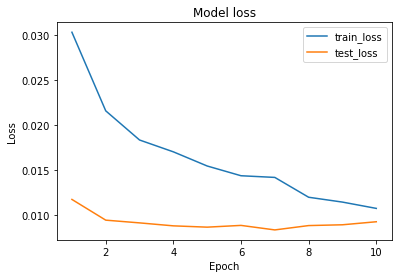

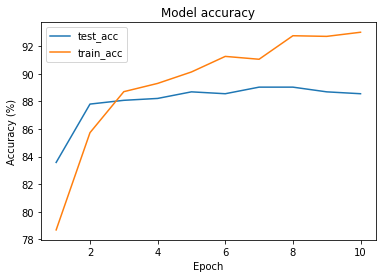


Epoch: 11 ;train_loss 0.0099 ; train_acc 94.15
Test set: Average loss: 0.0094, Accuracy: 1308/1467 (89%)


Epoch: 12 ;train_loss 0.0087 ; train_acc 94.59
Test set: Average loss: 0.0102, Accuracy: 1301/1467 (89%)


Epoch: 13 ;train_loss 0.0077 ; train_acc 95.49
Test set: Average loss: 0.0100, Accuracy: 1303/1467 (89%)


Epoch: 14 ;train_loss 0.0073 ; train_acc 95.70
Test set: Average loss: 0.0099, Accuracy: 1297/1467 (88%)


Epoch: 15 ;train_loss 0.0069 ; train_acc 95.88
Test set: Average loss: 0.0115, Accuracy: 1295/1467 (88%)



KeyboardInterrupt: ignored

In [24]:
model1 = ResNet18(device,True).model
criterion = nn.CrossEntropyLoss()
### Adam with optim with lr:= 0.0001
optimizer = optim.Adam(model1.parameters(), lr=0.00001)
model1.to(device)

epochs = 30                                                                 ### Set no. of epochs
model_saving_epochs = [1,2,3,5,10, 30, 50]                                             ### List of model saving checkpoints
model_dir = './Saved_models/resnet_fullmodel'

start = timeit.default_timer()

#train_loss,test_loss,test_acc = np.zeros(epochs),np.zeros(epochs),np.zeros(epochs) 
train_loss,test_loss,train_acc,test_acc = [],[],[],[]
for epoch in range(1, epochs+1):
    #print(epoch)
    train_loss_epoch,train_acc_epoch = train(model1, device, train_dl, criterion, optimizer, epoch,model_saving_epochs,model_dir)
    test_loss_epoch,test_acc_epoch = test(model1, device, val_dl, criterion)
    test_loss.append(test_loss_epoch) ; test_acc.append(test_acc_epoch) ; train_loss.append(train_loss_epoch) ; train_acc.append(train_acc_epoch)

    if (epoch%10 == 0):
      plot_results(train_loss,test_loss,train_acc,test_acc)

    
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

# Grad Cam visualisation

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
from torchvision import models
from PIL import Image


class Feat_Extractor():
    """ register gradients get activations from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            
            #print(x)
            if name in self.target_layers:
                #print(module)
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class Netout():
    """ Get network output through forward pass and get intermediate layer representation
    and gradient computation for targeted intermediate layer  """

    def __init__(self, net, feat_module, target_layers):
        self.model = net
        self.feature_module = feat_module
        self.feature_extractor = Feat_Extractor(self.feature_module,target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)

            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
    
            else:
                x = module(x)
        
        return target_activations, x


#visualize heatmap on input image
def visualize(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img = np.uint8(255 * cam)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()


class GradientCam:
    def __init__(self, model, feature_module, target_layer_, cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = Netout(self.model, self.feature_module, target_layer_)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        
        ''' This function should Return weights corresponding to each feature map of last convolution layer.
        Note that, linear combination of such weights with last conv layer feature map finally 
        produce the explanation map'''

        ### YOUR CODE STARTS HERE
        
        activation,output = self.extractor(input)   ### Extracting the activation from the target layer and model output of input
        A_k = activation[0][0].data.cpu().numpy()         ### Discarding the list and first dim

        if index == None:
          index = np.argmax(output.data.cpu().numpy())    ### Case for finding map for certain class

        score_label = output[0][index]              ### As in previous ques
        self.model.zero_grad() ### Nullyfying gradients to zero
        score_label.backward()

        channel_grads_list = self.extractor.get_gradients()   ### Finding the gradients per channel
        #print(np.shape(channel_grads_list[0]))
        channel_grads = channel_grads_list[0][0].data.cpu().numpy()


        weights = np.mean(channel_grads,axis = (1,2))         ## Weights determined by averaging over h and w
        CAM = np.zeros((A_k[0].shape),dtype = np.float32)

        for i in range(len(weights)):
          
          CAM += weights[i]*A_k[i,:,:]                       ### The net class activation by weightinh the obtained activations per channel
        
        ### Normalisation:
        CAM = np.maximum(CAM,0)    
        
        CAM_mini = np.min(CAM)
        CAM_maxi = np.max(CAM)                          ### Thresholding
        CAM = (CAM - CAM_mini)/(CAM_maxi - CAM_mini)### Min max scaling
        CAM = cv2.resize(CAM,(224,224))

        return weights,CAM,index,output
        ### YOUR CODE ENDS HERE

In [35]:
model_dir = './Saved_models/resnet_fullmodel'

m0 = torch.load(model_dir + '/resnet18_epoch-2.pth')

In [42]:
m0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
if __name__ == '__main__':

    net = m0
    grad_cam = GradientCam(model=net, feature_module=net.layer4, 
                           target_layer_=["1"], cuda=False)
    
    target_index = None

    ### call to grad_cam method should return the importance vector corresponds to
    ### each feature map of last convolution layer of pretrained Resnet50

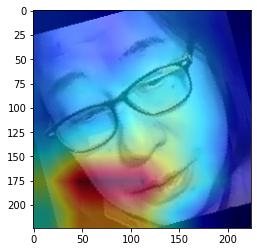

Label: NOT smile , Predicted: NOT smile


In [38]:

X, label = train_ds[1000]
X = X.unsqueeze_(0)
X = X.cuda()
X = X.requires_grad_(True)

#print(X[0].shape)
img = np.transpose(X[0].cpu().detach().numpy(),(1,2,0))
#print(img.shape)

weights, class_activation_map,pred,out = grad_cam(X) 
visualize(img, class_activation_map)


print('Label:', train_dataset.classes[label], ', Predicted:', train_dataset.classes[pred])

## False predictions

0
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9679, 0.0321]], device='cuda:0', grad_fn=<SoftmaxBackward>)
1
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9431, 0.0569]], device='cuda:0', grad_fn=<SoftmaxBackward>)
2
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9586, 0.0414]], device='cuda:0', grad_fn=<SoftmaxBackward>)
3
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8923, 0.1077]], device='cuda:0', grad_fn=<SoftmaxBackward>)
4
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9517, 0.0483]], device='cuda:0', grad_fn=<SoftmaxBackward>)
5
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8624, 0.1376]], device='cuda:0', grad_fn=<SoftmaxBackward>)
6
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9792, 0.0208]], device='cuda:0', grad_fn=<SoftmaxBackward>)
7
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9132, 0.0868]], device='cuda:0', grad_fn=<SoftmaxBackward>)
8
Label:

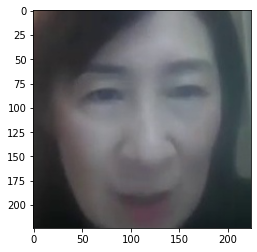

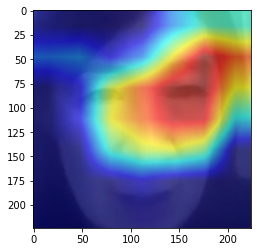

14
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.5554, 0.4446]], device='cuda:0', grad_fn=<SoftmaxBackward>)
15
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9177, 0.0823]], device='cuda:0', grad_fn=<SoftmaxBackward>)
16
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9722, 0.0278]], device='cuda:0', grad_fn=<SoftmaxBackward>)
17
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.2597, 0.7403]], device='cuda:0', grad_fn=<SoftmaxBackward>)


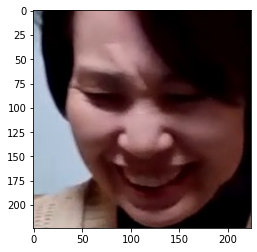

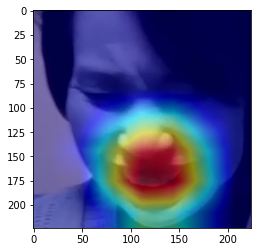

18
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9200, 0.0800]], device='cuda:0', grad_fn=<SoftmaxBackward>)
19
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.1769, 0.8231]], device='cuda:0', grad_fn=<SoftmaxBackward>)


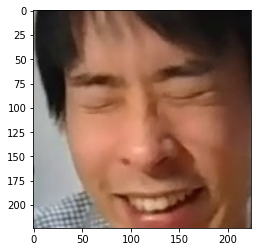

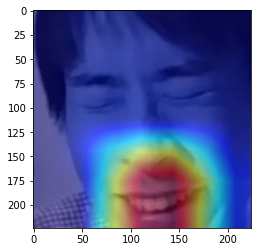

20
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9424, 0.0576]], device='cuda:0', grad_fn=<SoftmaxBackward>)
21
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9651, 0.0349]], device='cuda:0', grad_fn=<SoftmaxBackward>)
22
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.5396, 0.4604]], device='cuda:0', grad_fn=<SoftmaxBackward>)
23
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9559, 0.0441]], device='cuda:0', grad_fn=<SoftmaxBackward>)
24
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9515, 0.0485]], device='cuda:0', grad_fn=<SoftmaxBackward>)
25
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6854, 0.3146]], device='cuda:0', grad_fn=<SoftmaxBackward>)
26
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9381, 0.0619]], device='cuda:0', grad_fn=<SoftmaxBackward>)
27
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7133, 0.2867]], device='cuda:0', grad_fn=<SoftmaxBackward>)


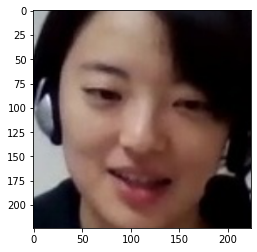

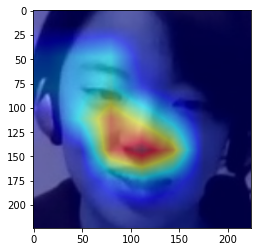

54
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.5868, 0.4132]], device='cuda:0', grad_fn=<SoftmaxBackward>)
55
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9764, 0.0236]], device='cuda:0', grad_fn=<SoftmaxBackward>)
56
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8597, 0.1403]], device='cuda:0', grad_fn=<SoftmaxBackward>)
57
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9891, 0.0109]], device='cuda:0', grad_fn=<SoftmaxBackward>)
58
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8996, 0.1004]], device='cuda:0', grad_fn=<SoftmaxBackward>)
59
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9688, 0.0312]], device='cuda:0', grad_fn=<SoftmaxBackward>)
60
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9549, 0.0451]], device='cuda:0', grad_fn=<SoftmaxBackward>)
61
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9731, 0.0269]], device='cuda:0', grad_fn=<SoftmaxBackward>)


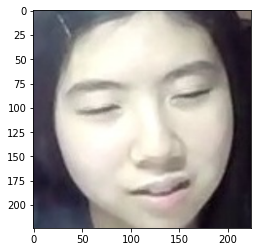

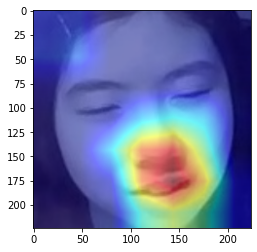

70
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9249, 0.0751]], device='cuda:0', grad_fn=<SoftmaxBackward>)
71
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8652, 0.1348]], device='cuda:0', grad_fn=<SoftmaxBackward>)
72
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9360, 0.0640]], device='cuda:0', grad_fn=<SoftmaxBackward>)
73
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9884, 0.0116]], device='cuda:0', grad_fn=<SoftmaxBackward>)
74
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8051, 0.1949]], device='cuda:0', grad_fn=<SoftmaxBackward>)
75
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8733, 0.1267]], device='cuda:0', grad_fn=<SoftmaxBackward>)
76
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8889, 0.1111]], device='cuda:0', grad_fn=<SoftmaxBackward>)
77
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9596, 0.0404]], device='cuda:0', grad_fn=<SoftmaxBackward>)


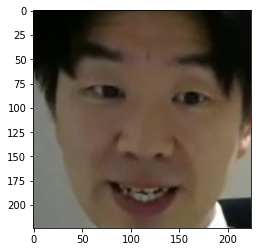

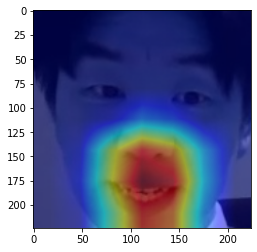

121
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9661, 0.0339]], device='cuda:0', grad_fn=<SoftmaxBackward>)
122
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8963, 0.1037]], device='cuda:0', grad_fn=<SoftmaxBackward>)
123
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9164, 0.0836]], device='cuda:0', grad_fn=<SoftmaxBackward>)
124
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9467, 0.0533]], device='cuda:0', grad_fn=<SoftmaxBackward>)
125
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9533, 0.0467]], device='cuda:0', grad_fn=<SoftmaxBackward>)
126
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9428, 0.0572]], device='cuda:0', grad_fn=<SoftmaxBackward>)
127
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7350, 0.2650]], device='cuda:0', grad_fn=<SoftmaxBackward>)
128
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8773, 0.1227]], device='cuda:0', grad_fn=<SoftmaxBac

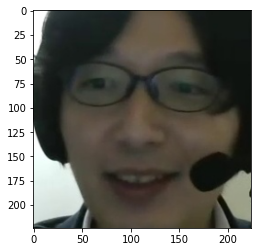

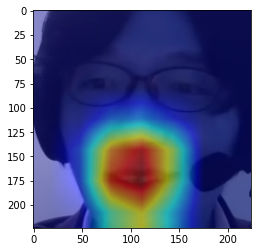

164
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9350, 0.0650]], device='cuda:0', grad_fn=<SoftmaxBackward>)
165
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8861, 0.1139]], device='cuda:0', grad_fn=<SoftmaxBackward>)
166
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9170, 0.0830]], device='cuda:0', grad_fn=<SoftmaxBackward>)
167
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9705, 0.0295]], device='cuda:0', grad_fn=<SoftmaxBackward>)
168
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8083, 0.1917]], device='cuda:0', grad_fn=<SoftmaxBackward>)
169
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9353, 0.0647]], device='cuda:0', grad_fn=<SoftmaxBackward>)
170
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8408, 0.1592]], device='cuda:0', grad_fn=<SoftmaxBackward>)
171
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8555, 0.1445]], device='cuda:0', grad_fn=<SoftmaxBac

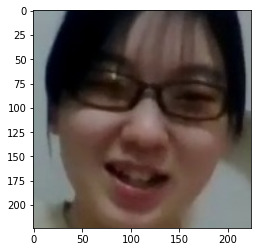

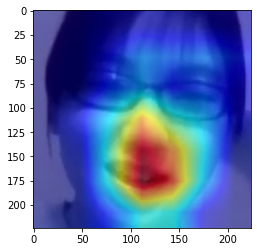

173
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8639, 0.1361]], device='cuda:0', grad_fn=<SoftmaxBackward>)
174
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9174, 0.0826]], device='cuda:0', grad_fn=<SoftmaxBackward>)
175
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9847, 0.0153]], device='cuda:0', grad_fn=<SoftmaxBackward>)
176
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8744, 0.1256]], device='cuda:0', grad_fn=<SoftmaxBackward>)
177
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6961, 0.3039]], device='cuda:0', grad_fn=<SoftmaxBackward>)
178
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9200, 0.0800]], device='cuda:0', grad_fn=<SoftmaxBackward>)
179
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8176, 0.1824]], device='cuda:0', grad_fn=<SoftmaxBackward>)
180
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9085, 0.0915]], device='cuda:0', grad_fn=<SoftmaxBac

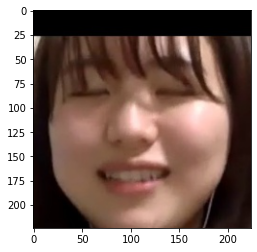

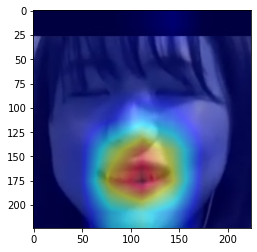

220
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8127, 0.1873]], device='cuda:0', grad_fn=<SoftmaxBackward>)
221
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9702, 0.0298]], device='cuda:0', grad_fn=<SoftmaxBackward>)
222
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8113, 0.1887]], device='cuda:0', grad_fn=<SoftmaxBackward>)
223
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9338, 0.0662]], device='cuda:0', grad_fn=<SoftmaxBackward>)
224
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8264, 0.1736]], device='cuda:0', grad_fn=<SoftmaxBackward>)
225
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8851, 0.1149]], device='cuda:0', grad_fn=<SoftmaxBackward>)
226
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9459, 0.0541]], device='cuda:0', grad_fn=<SoftmaxBackward>)
227
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7321, 0.2679]], device='cuda:0', grad_fn=<SoftmaxBac

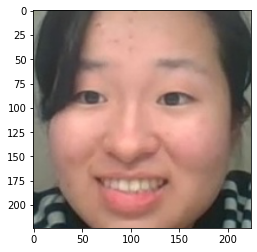

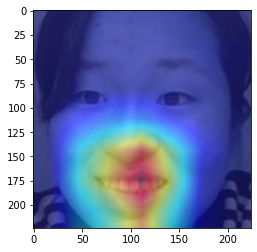

239
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8239, 0.1761]], device='cuda:0', grad_fn=<SoftmaxBackward>)
240
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9720, 0.0280]], device='cuda:0', grad_fn=<SoftmaxBackward>)
241
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9089, 0.0911]], device='cuda:0', grad_fn=<SoftmaxBackward>)
242
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9127, 0.0873]], device='cuda:0', grad_fn=<SoftmaxBackward>)
243
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9208, 0.0792]], device='cuda:0', grad_fn=<SoftmaxBackward>)
244
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8457, 0.1543]], device='cuda:0', grad_fn=<SoftmaxBackward>)
245
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9305, 0.0695]], device='cuda:0', grad_fn=<SoftmaxBackward>)
246
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8661, 0.1339]], device='cuda:0', grad_fn=<SoftmaxBac

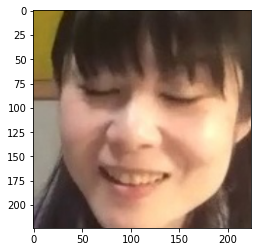

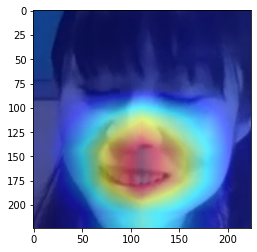

273
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9424, 0.0576]], device='cuda:0', grad_fn=<SoftmaxBackward>)
274
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6608, 0.3392]], device='cuda:0', grad_fn=<SoftmaxBackward>)
275
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9736, 0.0264]], device='cuda:0', grad_fn=<SoftmaxBackward>)
276
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7662, 0.2338]], device='cuda:0', grad_fn=<SoftmaxBackward>)
277
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9714, 0.0286]], device='cuda:0', grad_fn=<SoftmaxBackward>)
278
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9810, 0.0190]], device='cuda:0', grad_fn=<SoftmaxBackward>)
279
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9016, 0.0984]], device='cuda:0', grad_fn=<SoftmaxBackward>)
280
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9233, 0.0767]], device='cuda:0', grad_fn=<SoftmaxBac

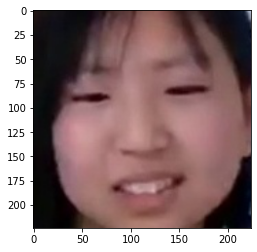

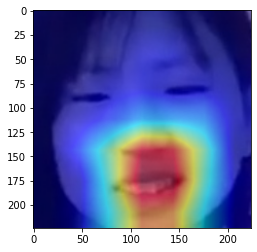

297
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8139, 0.1861]], device='cuda:0', grad_fn=<SoftmaxBackward>)
298
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8526, 0.1474]], device='cuda:0', grad_fn=<SoftmaxBackward>)
299
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9426, 0.0574]], device='cuda:0', grad_fn=<SoftmaxBackward>)
300
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7341, 0.2659]], device='cuda:0', grad_fn=<SoftmaxBackward>)
301
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9083, 0.0917]], device='cuda:0', grad_fn=<SoftmaxBackward>)
302
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9752, 0.0248]], device='cuda:0', grad_fn=<SoftmaxBackward>)
303
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9775, 0.0225]], device='cuda:0', grad_fn=<SoftmaxBackward>)
304
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.5361, 0.4639]], device='cuda:0', grad_fn=<SoftmaxBac

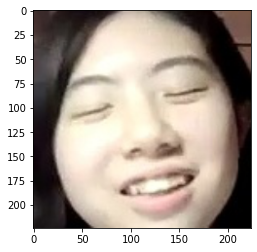

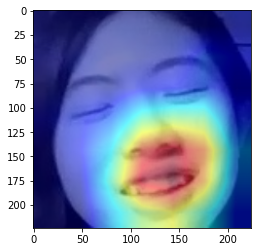

306
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7948, 0.2052]], device='cuda:0', grad_fn=<SoftmaxBackward>)
307
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8537, 0.1463]], device='cuda:0', grad_fn=<SoftmaxBackward>)
308
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9690, 0.0310]], device='cuda:0', grad_fn=<SoftmaxBackward>)
309
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7135, 0.2865]], device='cuda:0', grad_fn=<SoftmaxBackward>)
310
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6919, 0.3081]], device='cuda:0', grad_fn=<SoftmaxBackward>)
311
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9833, 0.0167]], device='cuda:0', grad_fn=<SoftmaxBackward>)
312
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9363, 0.0637]], device='cuda:0', grad_fn=<SoftmaxBackward>)
313
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8635, 0.1365]], device='cuda:0', grad_fn=<SoftmaxBac

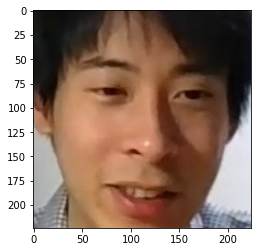

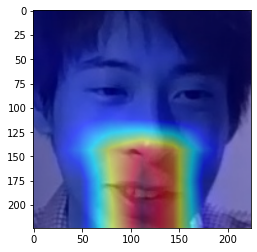

353
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9473, 0.0527]], device='cuda:0', grad_fn=<SoftmaxBackward>)
354
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9364, 0.0636]], device='cuda:0', grad_fn=<SoftmaxBackward>)
355
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9219, 0.0781]], device='cuda:0', grad_fn=<SoftmaxBackward>)
356
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9075, 0.0925]], device='cuda:0', grad_fn=<SoftmaxBackward>)
357
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.2449, 0.7551]], device='cuda:0', grad_fn=<SoftmaxBackward>)


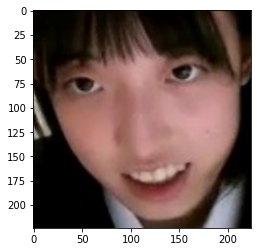

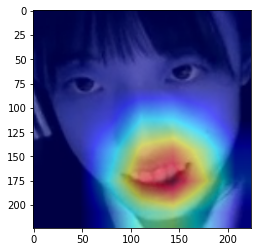

358
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9528, 0.0472]], device='cuda:0', grad_fn=<SoftmaxBackward>)
359
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9022, 0.0978]], device='cuda:0', grad_fn=<SoftmaxBackward>)
360
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.4433, 0.5567]], device='cuda:0', grad_fn=<SoftmaxBackward>)


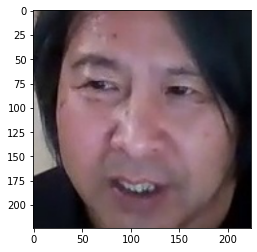

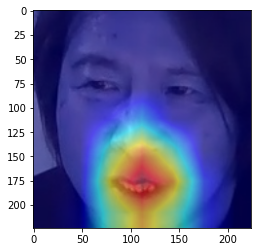

361
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9459, 0.0541]], device='cuda:0', grad_fn=<SoftmaxBackward>)
362
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9495, 0.0505]], device='cuda:0', grad_fn=<SoftmaxBackward>)
363
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8875, 0.1125]], device='cuda:0', grad_fn=<SoftmaxBackward>)
364
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8540, 0.1460]], device='cuda:0', grad_fn=<SoftmaxBackward>)
365
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9405, 0.0595]], device='cuda:0', grad_fn=<SoftmaxBackward>)
366
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9642, 0.0358]], device='cuda:0', grad_fn=<SoftmaxBackward>)
367
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8415, 0.1585]], device='cuda:0', grad_fn=<SoftmaxBackward>)
368
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9007, 0.0993]], device='cuda:0', grad_fn=<SoftmaxBac

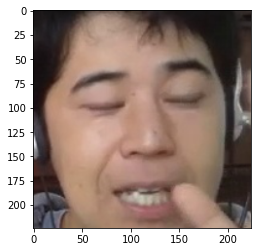

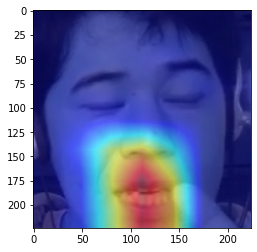

402
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9734, 0.0266]], device='cuda:0', grad_fn=<SoftmaxBackward>)
403
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8271, 0.1729]], device='cuda:0', grad_fn=<SoftmaxBackward>)
404
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9122, 0.0878]], device='cuda:0', grad_fn=<SoftmaxBackward>)
405
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7309, 0.2691]], device='cuda:0', grad_fn=<SoftmaxBackward>)
406
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9923, 0.0077]], device='cuda:0', grad_fn=<SoftmaxBackward>)
407
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9847, 0.0153]], device='cuda:0', grad_fn=<SoftmaxBackward>)
408
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6346, 0.3654]], device='cuda:0', grad_fn=<SoftmaxBackward>)
409
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7054, 0.2946]], device='cuda:0', grad_fn=<SoftmaxBac

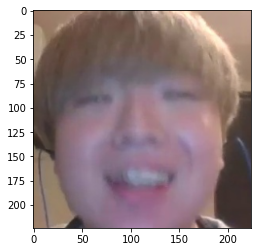

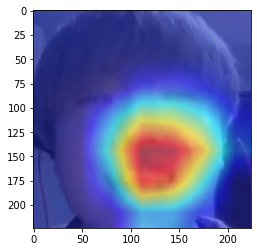

433
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8481, 0.1519]], device='cuda:0', grad_fn=<SoftmaxBackward>)
434
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9610, 0.0390]], device='cuda:0', grad_fn=<SoftmaxBackward>)
435
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6974, 0.3026]], device='cuda:0', grad_fn=<SoftmaxBackward>)
436
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6133, 0.3867]], device='cuda:0', grad_fn=<SoftmaxBackward>)
437
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9646, 0.0354]], device='cuda:0', grad_fn=<SoftmaxBackward>)
438
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9154, 0.0846]], device='cuda:0', grad_fn=<SoftmaxBackward>)
439
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8724, 0.1276]], device='cuda:0', grad_fn=<SoftmaxBackward>)
440
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9851, 0.0149]], device='cuda:0', grad_fn=<SoftmaxBac

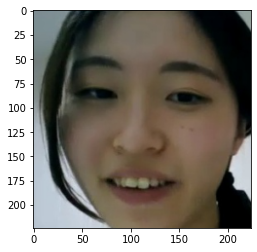

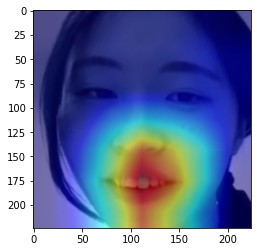

457
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8344, 0.1656]], device='cuda:0', grad_fn=<SoftmaxBackward>)
458
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7821, 0.2179]], device='cuda:0', grad_fn=<SoftmaxBackward>)
459
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9613, 0.0387]], device='cuda:0', grad_fn=<SoftmaxBackward>)
460
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7173, 0.2827]], device='cuda:0', grad_fn=<SoftmaxBackward>)
461
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9315, 0.0685]], device='cuda:0', grad_fn=<SoftmaxBackward>)
462
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8456, 0.1544]], device='cuda:0', grad_fn=<SoftmaxBackward>)
463
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7200, 0.2800]], device='cuda:0', grad_fn=<SoftmaxBackward>)
464
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9327, 0.0673]], device='cuda:0', grad_fn=<SoftmaxBac

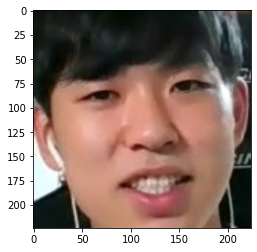

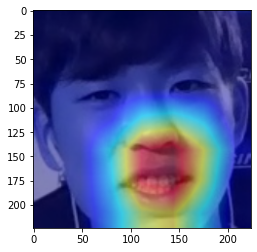

481
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8992, 0.1008]], device='cuda:0', grad_fn=<SoftmaxBackward>)
482
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9604, 0.0396]], device='cuda:0', grad_fn=<SoftmaxBackward>)
483
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9740, 0.0260]], device='cuda:0', grad_fn=<SoftmaxBackward>)
484
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8649, 0.1351]], device='cuda:0', grad_fn=<SoftmaxBackward>)
485
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.2757, 0.7243]], device='cuda:0', grad_fn=<SoftmaxBackward>)


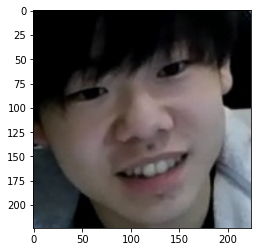

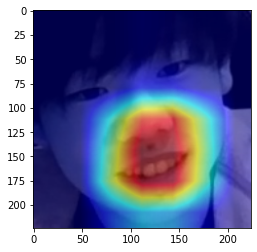

486
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9487, 0.0513]], device='cuda:0', grad_fn=<SoftmaxBackward>)
487
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8966, 0.1034]], device='cuda:0', grad_fn=<SoftmaxBackward>)
488
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8236, 0.1764]], device='cuda:0', grad_fn=<SoftmaxBackward>)
489
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9437, 0.0563]], device='cuda:0', grad_fn=<SoftmaxBackward>)
490
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8148, 0.1852]], device='cuda:0', grad_fn=<SoftmaxBackward>)
491
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9135, 0.0865]], device='cuda:0', grad_fn=<SoftmaxBackward>)
492
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9079, 0.0921]], device='cuda:0', grad_fn=<SoftmaxBackward>)
493
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.4009, 0.5991]], device='cuda:0', grad_fn=<Softm

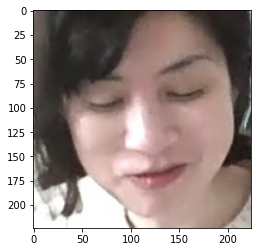

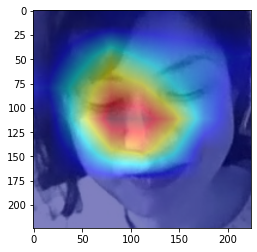

494
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9561, 0.0439]], device='cuda:0', grad_fn=<SoftmaxBackward>)
495
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8867, 0.1133]], device='cuda:0', grad_fn=<SoftmaxBackward>)
496
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9833, 0.0167]], device='cuda:0', grad_fn=<SoftmaxBackward>)
497
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7868, 0.2132]], device='cuda:0', grad_fn=<SoftmaxBackward>)
498
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9428, 0.0572]], device='cuda:0', grad_fn=<SoftmaxBackward>)
499
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9804, 0.0196]], device='cuda:0', grad_fn=<SoftmaxBackward>)
500
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7097, 0.2903]], device='cuda:0', grad_fn=<SoftmaxBackward>)
501
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9884, 0.0116]], device='cuda:0', grad_fn=<SoftmaxBac

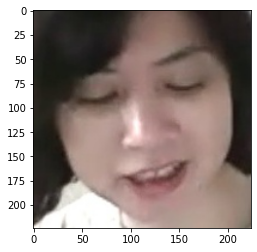

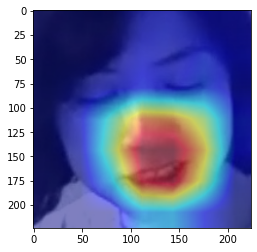

510
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8575, 0.1425]], device='cuda:0', grad_fn=<SoftmaxBackward>)
511
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6648, 0.3352]], device='cuda:0', grad_fn=<SoftmaxBackward>)
512
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9757, 0.0243]], device='cuda:0', grad_fn=<SoftmaxBackward>)
513
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9767, 0.0233]], device='cuda:0', grad_fn=<SoftmaxBackward>)
514
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8666, 0.1334]], device='cuda:0', grad_fn=<SoftmaxBackward>)
515
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9287, 0.0713]], device='cuda:0', grad_fn=<SoftmaxBackward>)
516
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.3186, 0.6814]], device='cuda:0', grad_fn=<SoftmaxBackward>)


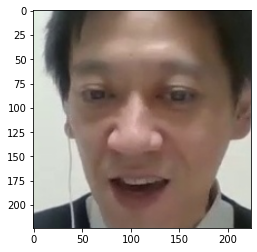

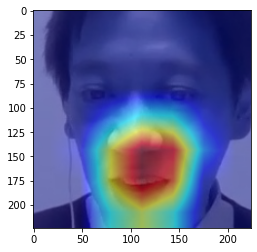

517
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8014, 0.1986]], device='cuda:0', grad_fn=<SoftmaxBackward>)
518
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9566, 0.0434]], device='cuda:0', grad_fn=<SoftmaxBackward>)
519
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9460, 0.0540]], device='cuda:0', grad_fn=<SoftmaxBackward>)
520
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9561, 0.0439]], device='cuda:0', grad_fn=<SoftmaxBackward>)
521
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9112, 0.0888]], device='cuda:0', grad_fn=<SoftmaxBackward>)
522
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8992, 0.1008]], device='cuda:0', grad_fn=<SoftmaxBackward>)
523
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9916, 0.0084]], device='cuda:0', grad_fn=<SoftmaxBackward>)
524
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9206, 0.0794]], device='cuda:0', grad_fn=<SoftmaxBac

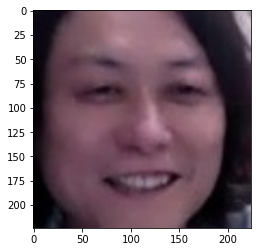

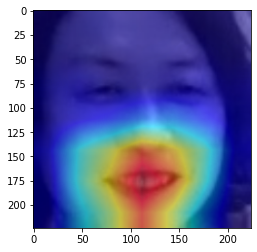

539
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9479, 0.0521]], device='cuda:0', grad_fn=<SoftmaxBackward>)
540
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9768, 0.0232]], device='cuda:0', grad_fn=<SoftmaxBackward>)
541
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7196, 0.2804]], device='cuda:0', grad_fn=<SoftmaxBackward>)
542
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9692, 0.0308]], device='cuda:0', grad_fn=<SoftmaxBackward>)
543
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.1292, 0.8708]], device='cuda:0', grad_fn=<SoftmaxBackward>)


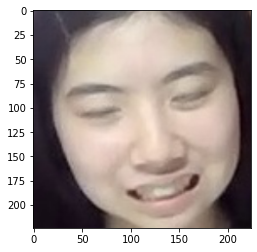

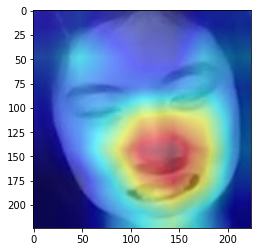

544
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9598, 0.0402]], device='cuda:0', grad_fn=<SoftmaxBackward>)
545
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.5814, 0.4186]], device='cuda:0', grad_fn=<SoftmaxBackward>)
546
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9273, 0.0727]], device='cuda:0', grad_fn=<SoftmaxBackward>)
547
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9170, 0.0830]], device='cuda:0', grad_fn=<SoftmaxBackward>)
548
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8586, 0.1414]], device='cuda:0', grad_fn=<SoftmaxBackward>)
549
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.4398, 0.5602]], device='cuda:0', grad_fn=<SoftmaxBackward>)


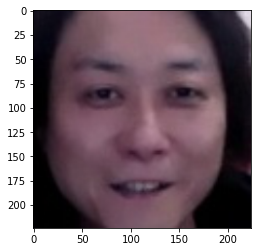

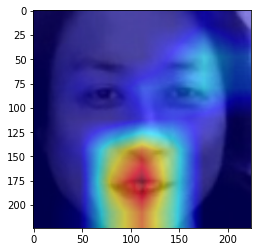

550
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8246, 0.1754]], device='cuda:0', grad_fn=<SoftmaxBackward>)
551
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9865, 0.0135]], device='cuda:0', grad_fn=<SoftmaxBackward>)
552
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8095, 0.1905]], device='cuda:0', grad_fn=<SoftmaxBackward>)
553
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9597, 0.0403]], device='cuda:0', grad_fn=<SoftmaxBackward>)
554
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9300, 0.0700]], device='cuda:0', grad_fn=<SoftmaxBackward>)
555
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8300, 0.1700]], device='cuda:0', grad_fn=<SoftmaxBackward>)
556
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9635, 0.0365]], device='cuda:0', grad_fn=<SoftmaxBackward>)
557
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9703, 0.0297]], device='cuda:0', grad_fn=<SoftmaxBac

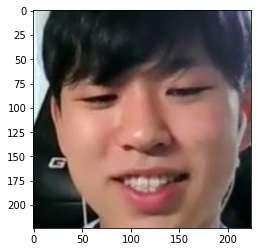

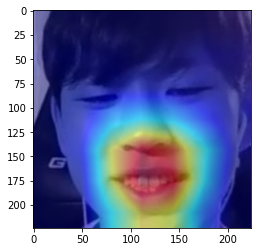

568
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9105, 0.0895]], device='cuda:0', grad_fn=<SoftmaxBackward>)
569
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8756, 0.1244]], device='cuda:0', grad_fn=<SoftmaxBackward>)
570
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8960, 0.1040]], device='cuda:0', grad_fn=<SoftmaxBackward>)
571
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8880, 0.1120]], device='cuda:0', grad_fn=<SoftmaxBackward>)
572
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8662, 0.1338]], device='cuda:0', grad_fn=<SoftmaxBackward>)
573
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9771, 0.0229]], device='cuda:0', grad_fn=<SoftmaxBackward>)
574
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9640, 0.0360]], device='cuda:0', grad_fn=<SoftmaxBackward>)
575
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.4515, 0.5485]], device='cuda:0', grad_fn=<Softm

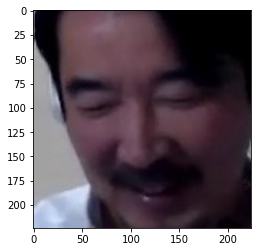

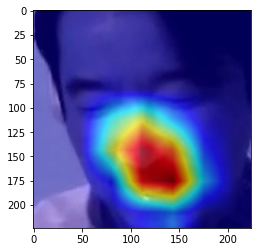

576
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9583, 0.0417]], device='cuda:0', grad_fn=<SoftmaxBackward>)
577
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9769, 0.0231]], device='cuda:0', grad_fn=<SoftmaxBackward>)
578
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7025, 0.2975]], device='cuda:0', grad_fn=<SoftmaxBackward>)
579
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9448, 0.0552]], device='cuda:0', grad_fn=<SoftmaxBackward>)
580
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9679, 0.0321]], device='cuda:0', grad_fn=<SoftmaxBackward>)
581
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7715, 0.2285]], device='cuda:0', grad_fn=<SoftmaxBackward>)
582
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9609, 0.0391]], device='cuda:0', grad_fn=<SoftmaxBackward>)
583
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9474, 0.0526]], device='cuda:0', grad_fn=<SoftmaxBac

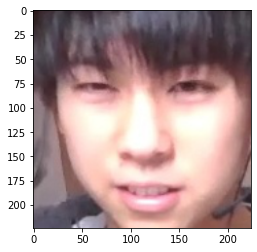

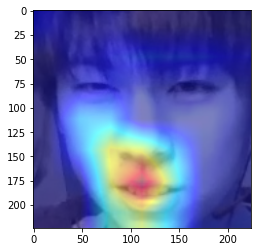

586
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8604, 0.1396]], device='cuda:0', grad_fn=<SoftmaxBackward>)
587
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8702, 0.1298]], device='cuda:0', grad_fn=<SoftmaxBackward>)
588
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8588, 0.1412]], device='cuda:0', grad_fn=<SoftmaxBackward>)
589
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8607, 0.1393]], device='cuda:0', grad_fn=<SoftmaxBackward>)
590
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8906, 0.1094]], device='cuda:0', grad_fn=<SoftmaxBackward>)
591
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7947, 0.2053]], device='cuda:0', grad_fn=<SoftmaxBackward>)
592
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6368, 0.3632]], device='cuda:0', grad_fn=<SoftmaxBackward>)
593
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6342, 0.3658]], device='cuda:0', grad_fn=<SoftmaxBac

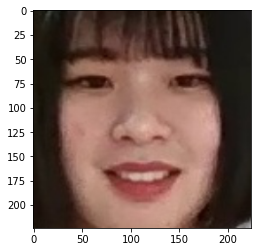

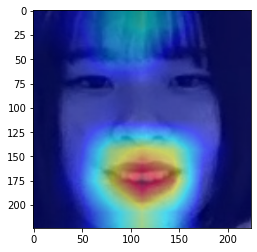

597
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9041, 0.0959]], device='cuda:0', grad_fn=<SoftmaxBackward>)
598
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8889, 0.1111]], device='cuda:0', grad_fn=<SoftmaxBackward>)
599
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.2056, 0.7944]], device='cuda:0', grad_fn=<SoftmaxBackward>)


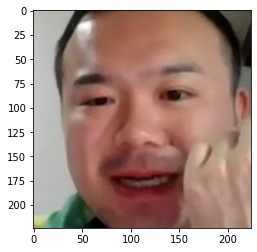

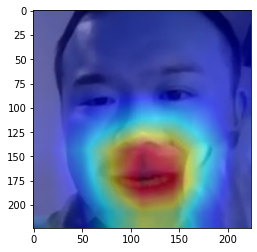

600
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9434, 0.0566]], device='cuda:0', grad_fn=<SoftmaxBackward>)
601
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9694, 0.0306]], device='cuda:0', grad_fn=<SoftmaxBackward>)
602
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9433, 0.0567]], device='cuda:0', grad_fn=<SoftmaxBackward>)
603
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7792, 0.2208]], device='cuda:0', grad_fn=<SoftmaxBackward>)
604
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9695, 0.0305]], device='cuda:0', grad_fn=<SoftmaxBackward>)
605
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8354, 0.1646]], device='cuda:0', grad_fn=<SoftmaxBackward>)
606
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9714, 0.0286]], device='cuda:0', grad_fn=<SoftmaxBackward>)
607
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7977, 0.2023]], device='cuda:0', grad_fn=<SoftmaxBac

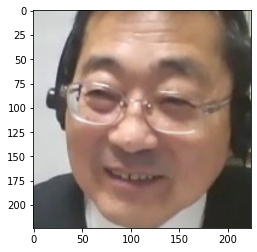

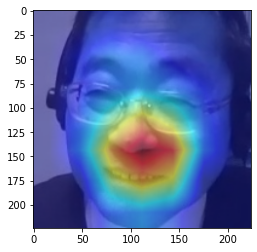

649
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8752, 0.1248]], device='cuda:0', grad_fn=<SoftmaxBackward>)
650
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8497, 0.1503]], device='cuda:0', grad_fn=<SoftmaxBackward>)
651
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8650, 0.1350]], device='cuda:0', grad_fn=<SoftmaxBackward>)
652
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.4717, 0.5283]], device='cuda:0', grad_fn=<SoftmaxBackward>)


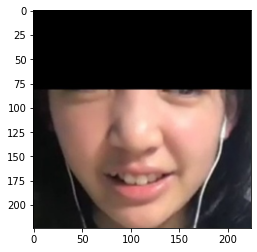

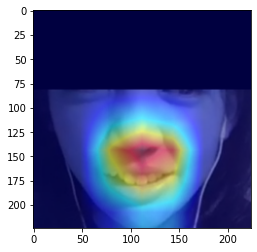

653
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9798, 0.0202]], device='cuda:0', grad_fn=<SoftmaxBackward>)
654
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7792, 0.2208]], device='cuda:0', grad_fn=<SoftmaxBackward>)
655
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9764, 0.0236]], device='cuda:0', grad_fn=<SoftmaxBackward>)
656
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9425, 0.0575]], device='cuda:0', grad_fn=<SoftmaxBackward>)
657
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9708, 0.0292]], device='cuda:0', grad_fn=<SoftmaxBackward>)
658
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9234, 0.0766]], device='cuda:0', grad_fn=<SoftmaxBackward>)
659
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9870, 0.0130]], device='cuda:0', grad_fn=<SoftmaxBackward>)
660
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8948, 0.1052]], device='cuda:0', grad_fn=<SoftmaxBac

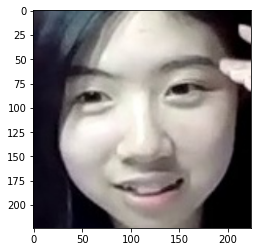

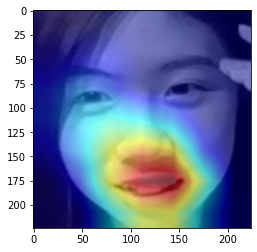

668
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9745, 0.0255]], device='cuda:0', grad_fn=<SoftmaxBackward>)
669
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8553, 0.1447]], device='cuda:0', grad_fn=<SoftmaxBackward>)
670
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9895, 0.0105]], device='cuda:0', grad_fn=<SoftmaxBackward>)
671
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8863, 0.1137]], device='cuda:0', grad_fn=<SoftmaxBackward>)
672
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.5052, 0.4948]], device='cuda:0', grad_fn=<SoftmaxBackward>)
673
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8720, 0.1280]], device='cuda:0', grad_fn=<SoftmaxBackward>)
674
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9790, 0.0210]], device='cuda:0', grad_fn=<SoftmaxBackward>)
675
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9191, 0.0809]], device='cuda:0', grad_fn=<SoftmaxBac

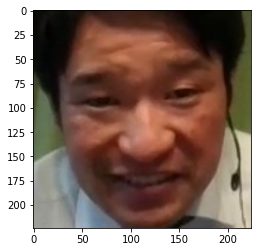

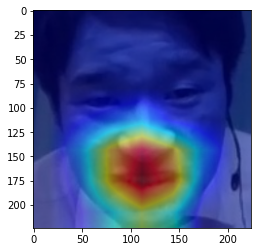

727
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9809, 0.0191]], device='cuda:0', grad_fn=<SoftmaxBackward>)
728
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9213, 0.0787]], device='cuda:0', grad_fn=<SoftmaxBackward>)
729
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9230, 0.0770]], device='cuda:0', grad_fn=<SoftmaxBackward>)
730
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9312, 0.0688]], device='cuda:0', grad_fn=<SoftmaxBackward>)
731
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6657, 0.3343]], device='cuda:0', grad_fn=<SoftmaxBackward>)
732
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9023, 0.0977]], device='cuda:0', grad_fn=<SoftmaxBackward>)
733
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9081, 0.0919]], device='cuda:0', grad_fn=<SoftmaxBackward>)
734
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9026, 0.0974]], device='cuda:0', grad_fn=<SoftmaxBac

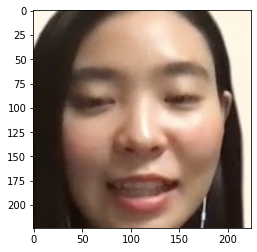

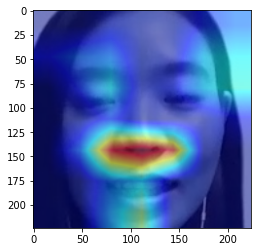

739
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9231, 0.0769]], device='cuda:0', grad_fn=<SoftmaxBackward>)
740
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9380, 0.0620]], device='cuda:0', grad_fn=<SoftmaxBackward>)
741
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9046, 0.0954]], device='cuda:0', grad_fn=<SoftmaxBackward>)
742
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7975, 0.2025]], device='cuda:0', grad_fn=<SoftmaxBackward>)
743
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8776, 0.1224]], device='cuda:0', grad_fn=<SoftmaxBackward>)
744
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8835, 0.1165]], device='cuda:0', grad_fn=<SoftmaxBackward>)
745
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8404, 0.1596]], device='cuda:0', grad_fn=<SoftmaxBackward>)
746
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8881, 0.1119]], device='cuda:0', grad_fn=<SoftmaxBac

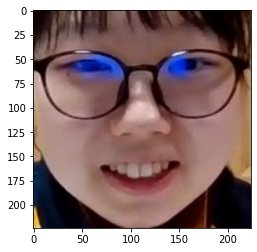

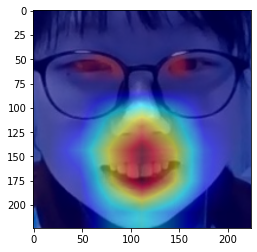

834
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9306, 0.0694]], device='cuda:0', grad_fn=<SoftmaxBackward>)
835
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9363, 0.0637]], device='cuda:0', grad_fn=<SoftmaxBackward>)
836
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6093, 0.3907]], device='cuda:0', grad_fn=<SoftmaxBackward>)
837
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7655, 0.2345]], device='cuda:0', grad_fn=<SoftmaxBackward>)
838
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8016, 0.1984]], device='cuda:0', grad_fn=<SoftmaxBackward>)
839
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9582, 0.0418]], device='cuda:0', grad_fn=<SoftmaxBackward>)
840
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9885, 0.0115]], device='cuda:0', grad_fn=<SoftmaxBackward>)
841
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9047, 0.0953]], device='cuda:0', grad_fn=<SoftmaxBac

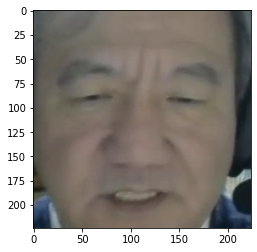

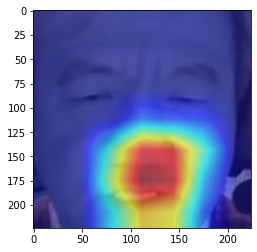

845
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9741, 0.0259]], device='cuda:0', grad_fn=<SoftmaxBackward>)
846
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8885, 0.1115]], device='cuda:0', grad_fn=<SoftmaxBackward>)
847
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8274, 0.1726]], device='cuda:0', grad_fn=<SoftmaxBackward>)
848
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9841, 0.0159]], device='cuda:0', grad_fn=<SoftmaxBackward>)
849
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9477, 0.0523]], device='cuda:0', grad_fn=<SoftmaxBackward>)
850
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9449, 0.0551]], device='cuda:0', grad_fn=<SoftmaxBackward>)
851
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8535, 0.1465]], device='cuda:0', grad_fn=<SoftmaxBackward>)
852
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7376, 0.2624]], device='cuda:0', grad_fn=<SoftmaxBac

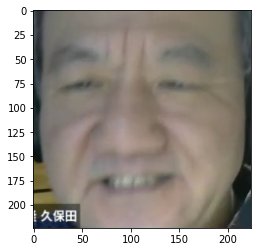

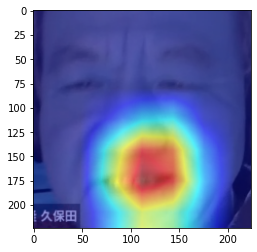

862
Label: NOT smile , Predicted: positive smile , Proba :  tensor([[0.4537, 0.5463]], device='cuda:0', grad_fn=<SoftmaxBackward>)


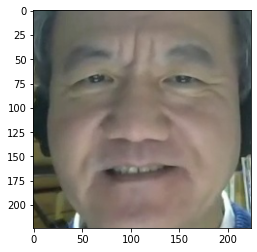

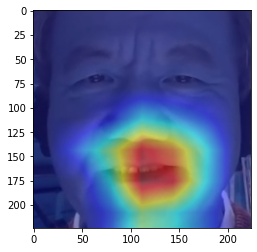

863
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9399, 0.0601]], device='cuda:0', grad_fn=<SoftmaxBackward>)
864
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9617, 0.0383]], device='cuda:0', grad_fn=<SoftmaxBackward>)
865
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9824, 0.0176]], device='cuda:0', grad_fn=<SoftmaxBackward>)
866
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9679, 0.0321]], device='cuda:0', grad_fn=<SoftmaxBackward>)
867
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8970, 0.1030]], device='cuda:0', grad_fn=<SoftmaxBackward>)
868
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7695, 0.2305]], device='cuda:0', grad_fn=<SoftmaxBackward>)
869
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9761, 0.0239]], device='cuda:0', grad_fn=<SoftmaxBackward>)
870
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9238, 0.0762]], device='cuda:0', grad_fn=<SoftmaxBac

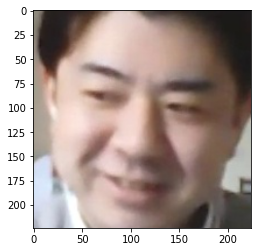

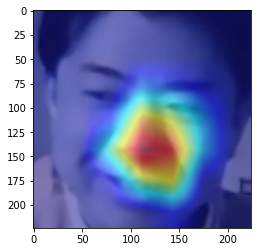

919
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9816, 0.0184]], device='cuda:0', grad_fn=<SoftmaxBackward>)
920
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9539, 0.0461]], device='cuda:0', grad_fn=<SoftmaxBackward>)
921
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9720, 0.0280]], device='cuda:0', grad_fn=<SoftmaxBackward>)
922
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9824, 0.0176]], device='cuda:0', grad_fn=<SoftmaxBackward>)
923
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8869, 0.1131]], device='cuda:0', grad_fn=<SoftmaxBackward>)
924
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.6790, 0.3210]], device='cuda:0', grad_fn=<SoftmaxBackward>)
925
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.7090, 0.2910]], device='cuda:0', grad_fn=<SoftmaxBackward>)
926
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9514, 0.0486]], device='cuda:0', grad_fn=<SoftmaxBac

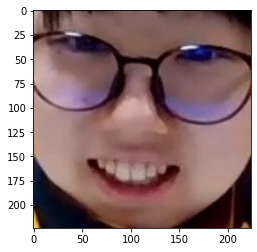

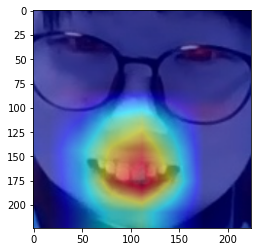

946
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9049, 0.0951]], device='cuda:0', grad_fn=<SoftmaxBackward>)
947
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9429, 0.0571]], device='cuda:0', grad_fn=<SoftmaxBackward>)
948
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9690, 0.0310]], device='cuda:0', grad_fn=<SoftmaxBackward>)
949
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9727, 0.0273]], device='cuda:0', grad_fn=<SoftmaxBackward>)
950
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9170, 0.0830]], device='cuda:0', grad_fn=<SoftmaxBackward>)
951
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.8336, 0.1664]], device='cuda:0', grad_fn=<SoftmaxBackward>)
952
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9125, 0.0875]], device='cuda:0', grad_fn=<SoftmaxBackward>)
953
Label: NOT smile , Predicted: NOT smile , Proba :  tensor([[0.9916, 0.0084]], device='cuda:0', grad_fn=<SoftmaxBac

KeyboardInterrupt: ignored

In [40]:
m = nn.Softmax(dim=1)
y_true = []
y_pred = []
for i in range(0,len(val_ds)):

  print(i)
  X, label = val_ds[i]
  X = X.unsqueeze_(0)
  X = X.cuda()
  X = X.requires_grad_(True)
  img = np.transpose(X[0].cpu().detach().numpy(),(1,2,0))
  weights, class_activation_map,pred,out = grad_cam(X)

  
  
  print('Label:', val_dataset.classes[label], ', Predicted:', val_dataset.classes[pred], ', Proba : ', m(out) )

  y_true.append(label); y_pred.append(pred)

  if(pred != label):

    plt.imshow(img)
    plt.show()
    visualize(img, class_activation_map)
    